In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 100% !important; }</style>"))

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pylab
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
from pmdarima.arima import auto_arima
import sklearn
import yfinance
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.distributions import chi2
sns.set()

In [3]:
raw_data = yfinance.download(tickers= "VOW3.DE, PAH3.DE, BMW.DE", interval= "1d",
                             group_by='ticker', auto_adjust=True, treads=True)
df= raw_data.copy()

[*********************100%***********************]  3 of 3 completed


## Definig Key Dates

In [4]:
## Starting Dates
start_date = "2009-04-05"

# First official Announcement - 49.9 %
ann_1 = "2009-12-09"

# Second Official Announcement - 50.1 %
ann_2 = '2012-07-05'

#Ending Date
end_date = "2014-01-01"

#Dieseigate Scandle
d_gate = "2015-09-20"

## Data Preprocessing

In [5]:
# Extracting closing prices
df['vol'] = df['VOW3.DE'].Close
df['por'] = df['PAH3.DE'].Close
df['bmw'] = df['BMW.DE'].Close

# Creating returns
df['ret_vol'] = df['vol'].pct_change(1).mul(100)
df['ret_por'] = df['por'].pct_change(1).mul(100)
df['ret_bmw'] = df['bmw'].pct_change(1).mul(100)

# Creating Squared Returns 
df['sq_vol'] = df.ret_vol.mul(df.ret_vol)
df['sq_por'] = df.ret_por.mul(df.ret_por)
df['sq_bmw'] = df.ret_bmw.mul(df.ret_bmw)

# Extracting Volume
df['q_vol'] = df['VOW3.DE'].Volume
df['q_por'] = df['PAH3.DE'].Volume
df['q_bmw'] = df['BMW.DE'].Volume

#Assigning the frequencies and filling na values 
df = df.asfreq('b')
df = df.fillna(method='ffill')

#Removing Surplus Data
del df['VOW3.DE'], df['PAH3.DE'], df['BMW.DE']

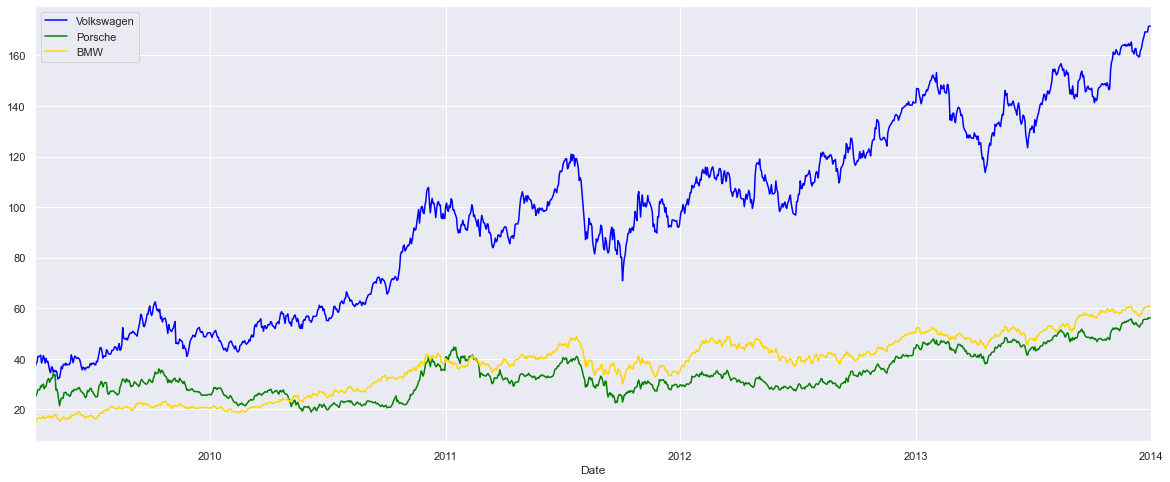

In [10]:
df['vol'][start_date:end_date].plot(figsize=(20,8), color='blue')
df['por'][start_date:end_date].plot(color='green')
df['bmw'][start_date:end_date].plot(color = 'gold')
plt.legend(['Volkswagen', 'Porsche', 'BMW']);

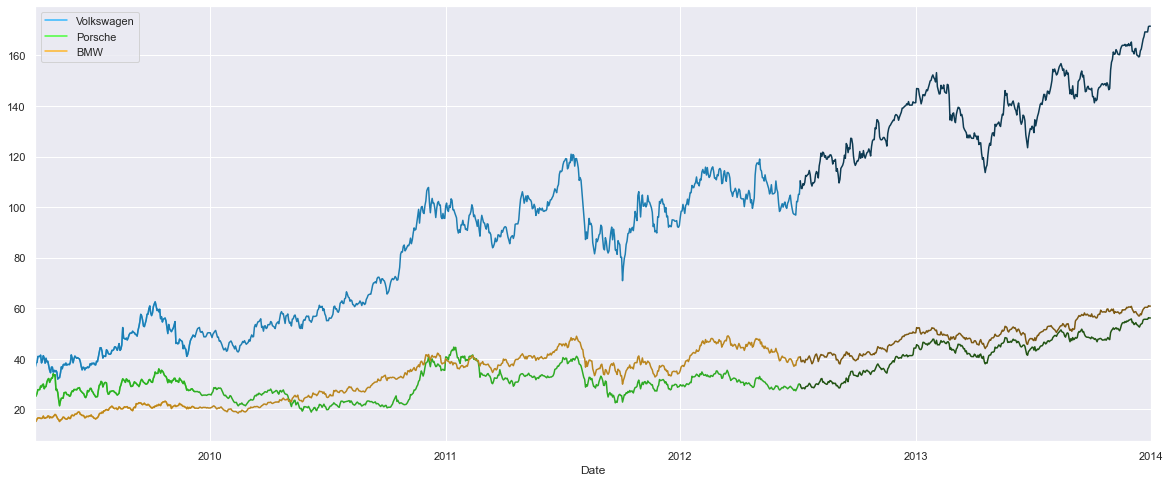

In [13]:
df['vol'][start_date:ann_1].plot(figsize=(20,8), color="#33B8FF")
df['por'][start_date:ann_1].plot(color="#49FF3A")
df['bmw'][start_date:ann_1].plot(color="#FEB628")

df['vol'][start_date:ann_2].plot(color="#1E7EB2")
df['por'][start_date:ann_2].plot(color="#2FAB25")
df['bmw'][start_date:ann_2].plot(color="#BA861F")

df['vol'][ann_2:end_date].plot(color="#0E3A52")
df['por'][ann_2:end_date].plot(color="#225414")
df['bmw'][ann_2:end_date].plot(color="#7C5913")
plt.legend(['Volkswagen', 'Porsche', 'BMW']);

## Correlation

In [19]:
print("Correlation among manufacturers from " + str(start_date)+' to '+str(end_date)+'\n')
print('Volkswagen and Porsche Correlation : \t'+str(df['vol'][start_date:end_date].corr(df['por'][start_date:end_date])))
print('Volkswagen and BMW Correlation : \t'+str(df['vol'][start_date:end_date].corr(df['bmw'][start_date:end_date])))
print('Porsche and BMW Correlation : \t\t'+str(df['por'][start_date:end_date].corr(df['bmw'][start_date:end_date])))

Correlation among manufacturers from 2009-04-05 to 2014-01-01

Volkswagen and Porsche Correlation : 	0.836463489610537
Volkswagen and BMW Correlation : 	0.9798969140121577
Porsche and BMW Correlation : 		0.8057254109700616


In [18]:
print("Correlation among manufacturers from " + str(start_date) + ' to ' + str(ann_1)+'\n')
print('Volkswagen and Porsche Correlation : \t'+str(df['vol'][start_date:ann_1].corr(df['por'][start_date:ann_1])))
print('Volkswagen and BMW Correlation : \t'+str(df['vol'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))
print('Porsche and BMW Correlation : \t\t'+str(df['por'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))

Correlation among manufacturers from 2009-04-05 to 2009-12-09

Volkswagen and Porsche Correlation : 	0.6762282895331967
Volkswagen and BMW Correlation : 	0.8441704493901624
Porsche and BMW Correlation : 		0.6217078064244117


In [21]:
print("Correlation among manufacturers from " + str(ann_1) + ' to ' + str(ann_2)+'\n')
print('Volkswagen and Porsche Correlation : \t'+str(df['vol'][ann_1:ann_2].corr(df['por'][ann_1:ann_2])))
print('Volkswagen and BMW Correlation : \t'+str(df['vol'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))
print('Porsche and BMW Correlation : \t\t'+str(df['por'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))

Correlation among manufacturers from 2009-12-09 to 2012-07-05

Volkswagen and Porsche Correlation : 	0.7434172638043377
Volkswagen and BMW Correlation : 	0.9795878022171979
Porsche and BMW Correlation : 		0.705117048256369


In [22]:
#After when the Volkswagen fully buys out porsche
print("Correlation among manufacturers from " + str(ann_2) + ' to ' + str(end_date)+'\n')
print('Volkswagen and Porsche Correlation : \t'+str(df['vol'][ann_2:end_date].corr(df['por'][ann_2:end_date])))
print('Volkswagen and BMW Correlation : \t'+str(df['vol'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))
print('Porsche and BMW Correlation : \t\t'+str(df['por'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))

Correlation among manufacturers from 2012-07-05 to 2014-01-01

Volkswagen and Porsche Correlation : 	0.9409609156594534
Volkswagen and BMW Correlation : 	0.929113129399825
Porsche and BMW Correlation : 		0.9497200055546388


In [23]:
print("Correlation among manufacturers from " + str(end_date) + ' to ' + str(df.index[-1])+'\n')
print('Volkswagen and Porsche Correlation : \t'+str(df['vol'][end_date:].corr(df['por'][end_date:])))
print('Volkswagen and BMW Correlation : \t'+str(df['vol'][end_date:].corr(df['bmw'][end_date:])))
print('Porsche and BMW Correlation : \t\t'+str(df['por'][end_date:].corr(df['bmw'][end_date:])))

Correlation among manufacturers from 2014-01-01 to 2021-08-20 00:00:00

Volkswagen and Porsche Correlation : 	0.9565811714374518
Volkswagen and BMW Correlation : 	0.6720016927931597
Porsche and BMW Correlation : 		0.6832182430479133


## For Volkswagen

In [26]:
mod_pr_pre_vol = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por', 'bmw']][start_date:ann_1],
                           m=5, max_p = 5, max_q=5)
mod_pr_btn_vol = auto_arima(df.vol[ann_1:ann_2], exogenous = df[['por', 'bmw']][ann_1:ann_2],
                           m=5, max_p=5, max_q = 5)
mod_pr_post_vol = auto_arima(df.vol[ann_2:end_date], exogenous = df[['por', 'bmw']][ann_2:end_date],
                           m=5, max_p=5, max_q = 5)

In [27]:
mod_pr_pre_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -322.972
Date:                Mon, 23 Aug 2021   AIC                            655.943
Time:                        10:33:16   BIC                            671.852
Sample:                    04-06-2009   HQIC                           662.395
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7291      0.447      1.631      0.103      -0.147       1.605
por            0.4002      0.096      4.170      0.000       0.212       0.588
bmw            0.6928      0.328      2.110      0.035       0.049       1.336
ar.L1          0.9630      0.020     48.641      0.000       0.924       1.002
sigma2         2.1734      0.148     14.721      0.000       1.884       2.463
===================================================================================
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):               165.78
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                            -0.52
Prob(H) (two-sided):                  0.07   Kurtosis:                         7.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
 mod_pr_btn_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1076.154
Date:                Mon, 23 Aug 2021   AIC                           2162.308
Time:                        10:33:23   BIC                           2184.852
Sample:                    12-09-2009   HQIC                          2171.039
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            0.7795      0.061     12.720      0.000       0.659       0.900
bmw            1.5687      0.074     21.285      0.000       1.424       1.713
ar.L1          0.9286      0.032     29.386      0.000       0.867       0.991
ma.L1         -0.9702      0.022    -44.774      0.000      -1.013      -0.928
sigma2         1.4469      0.060     24.263      0.000       1.330       1.564
===================================================================================
Ljung-Box (L1) (Q):                   1.10   Jarque-Bera (JB):               111.47
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               1.66   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
mod_pr_post_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -607.491
Date:                Mon, 23 Aug 2021   AIC                           1220.983
Time:                        10:35:53   BIC                           1232.874
Sample:                    07-05-2012   HQIC                          1225.697
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            1.7203      0.057     30.441      0.000       1.610       1.831
bmw            0.8508      0.092      9.291      0.000       0.671       1.030
sigma2         1.3304      0.065     20.496      0.000       1.203       1.458
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):               105.52
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -0.40
Prob(H) (two-sided):                  0.14   Kurtosis:                         5.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## For Porsche

In [30]:
mod_pr_pre_vol = auto_arima(df.por[start_date:ann_1], exogenous = df[['vol', 'bmw']][start_date:ann_1],
                           m=5, max_p = 5, max_q=5)
mod_pr_btn_vol = auto_arima(df.por[ann_1:ann_2], exogenous = df[['vol', 'bmw']][ann_1:ann_2],
                           m=5, max_p=5, max_q = 5)
mod_pr_post_vol = auto_arima(df.por[ann_2:end_date], exogenous = df[['vol', 'bmw']][ann_2:end_date],
                           m=5, max_p=5, max_q = 5)

In [31]:
mod_pr_pre_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  178
Model:             SARIMAX(1, 0, 0)x(0, 0, [1, 2], 5)   Log Likelihood                -224.907
Date:                                Mon, 23 Aug 2021   AIC                            463.813
Time:                                        10:41:10   BIC                            486.086
Sample:                                    04-06-2009   HQIC                           472.845
                                         - 12-09-2009                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3530      0.294      1.199      0.231      -0.224       0.930
vol            0.1476      0.052      2.834      0.005       0.046       0.250
bmw            0.8162      0.168      4.869      0.000       0.488       1.145
ar.L1          0.9466      0.028     34.162      0.000       0.892       1.001
ma.S.L5       -0.1051      0.076     -1.375      0.169      -0.255       0.045
ma.S.L10      -0.1865      0.085     -2.199      0.028      -0.353      -0.020
sigma2         0.7235      0.061     11.950      0.000       0.605       0.842
===================================================================================
Ljung-Box (L1) (Q):                   1.10   Jarque-Bera (JB):               334.98
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
mod_pr_btn_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -580.831
Date:                Mon, 23 Aug 2021   AIC                           1171.662
Time:                        10:42:44   BIC                           1194.205
Sample:                    12-09-2009   HQIC                          1180.393
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vol            0.1781      0.016     11.105      0.000       0.147       0.210
bmw            0.3325      0.046      7.222      0.000       0.242       0.423
ar.L1          0.6711      0.216      3.104      0.002       0.247       1.095
ma.L1         -0.6022      0.232     -2.592      0.010      -1.058      -0.147
sigma2         0.3307      0.010     32.428      0.000       0.311       0.351
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1076.61
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.05
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
mod_pr_post_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  390
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 5)   Log Likelihood                -209.114
Date:                             Mon, 23 Aug 2021   AIC                            426.227
Time:                                     10:43:01   BIC                            442.082
Sample:                                 07-05-2012   HQIC                           432.513
                                      - 01-01-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vol            0.2220      0.013     16.953      0.000       0.196       0.248
bmw            0.2549      0.041      6.192      0.000       0.174       0.336
ma.S.L5       -0.1426      0.056     -2.530      0.011      -0.253      -0.032
sigma2         0.1715      0.006     28.018      0.000       0.160       0.184
===================================================================================
Ljung-Box (L1) (Q):                   0.96   Jarque-Bera (JB):               628.03
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predictions for the future

#### For Porsche

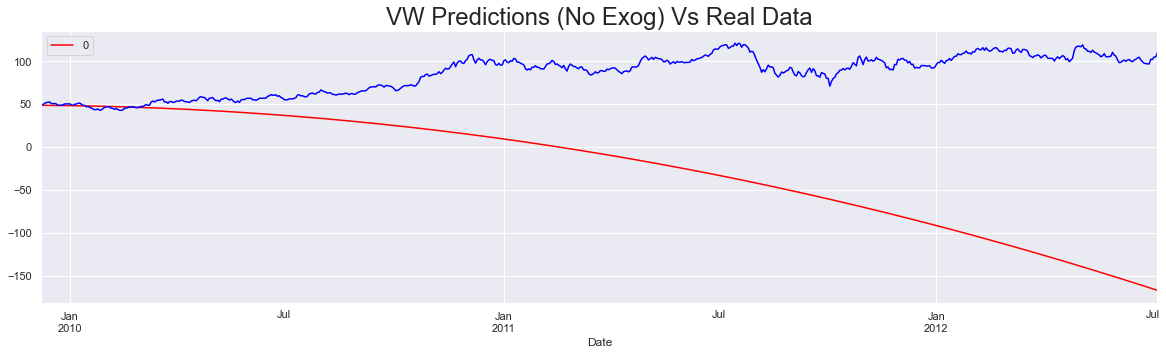

In [34]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], m=5, max_p=5, max_q=5, max_P=5, max_Q=5, trend="ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2])), index=df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color= 'red')

df.vol[ann_1:ann_2].plot(color='blue')
plt.title('VW Predictions (No Exog) Vs Real Data', size=24);

## For Volkswagen

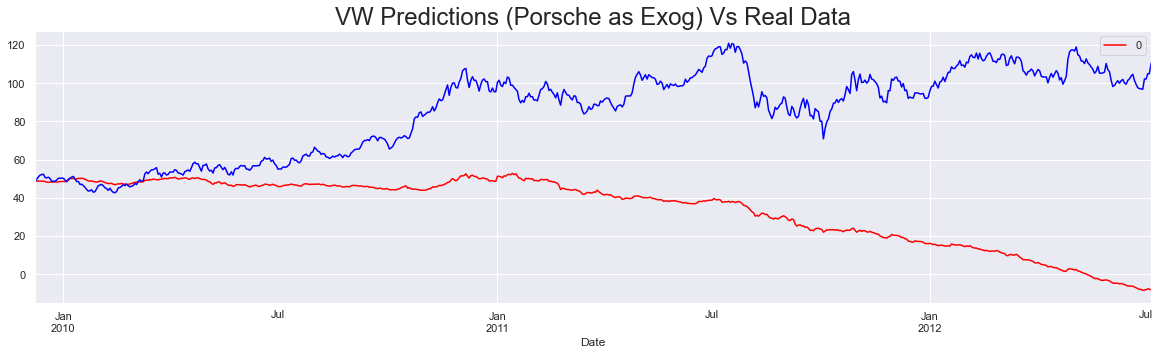

In [36]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por']][start_date:ann_1],
                                m=5, max_p=5, max_q=5, max_P=5, max_Q=5, trend="ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]),
                                                          exogenous = df[['por']][ann_1:ann_2]), index=df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color= 'red')

df.vol[ann_1:ann_2].plot(color='blue')
plt.title('VW Predictions (Porsche as Exog) Vs Real Data', size=24);

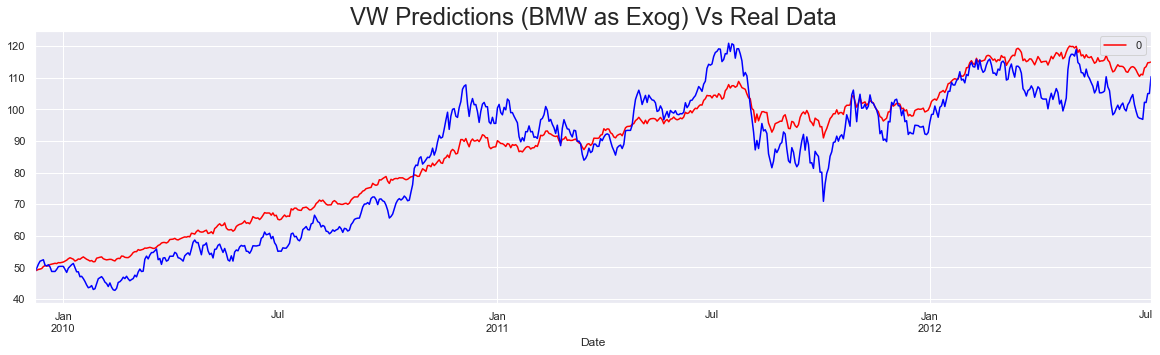

In [37]:
 model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df[['bmw']][start_date:ann_1],
                                m=5, max_p=5, max_q=5, max_P=5, max_Q=5, trend="ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]),
                                                          exogenous = df[['bmw']][ann_1:ann_2]), index=df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color= 'red')

df.vol[ann_1:ann_2].plot(color='blue')
plt.title('VW Predictions (BMW as Exog) Vs Real Data', size=24);

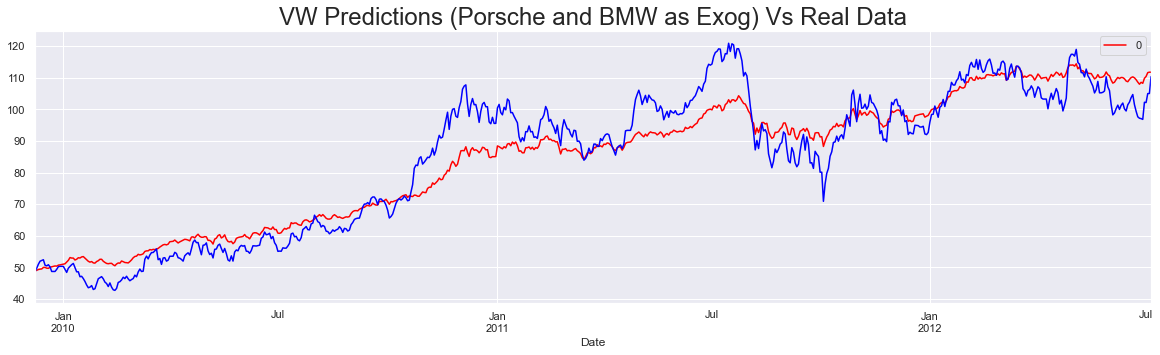

In [38]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por', 'bmw']][start_date:ann_1],
                                m=5, max_p=5, max_q=5, max_P=5, max_Q=5, trend="ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]),
                                                          exogenous = df[['por', 'bmw']][ann_1:ann_2]), index=df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color= 'red')

df.vol[ann_1:ann_2].plot(color='blue')
plt.title('VW Predictions (Porsche and BMW as Exog) Vs Real Data', size=24);

## Volatility

#### Volatility of Volkwagen for each preriod

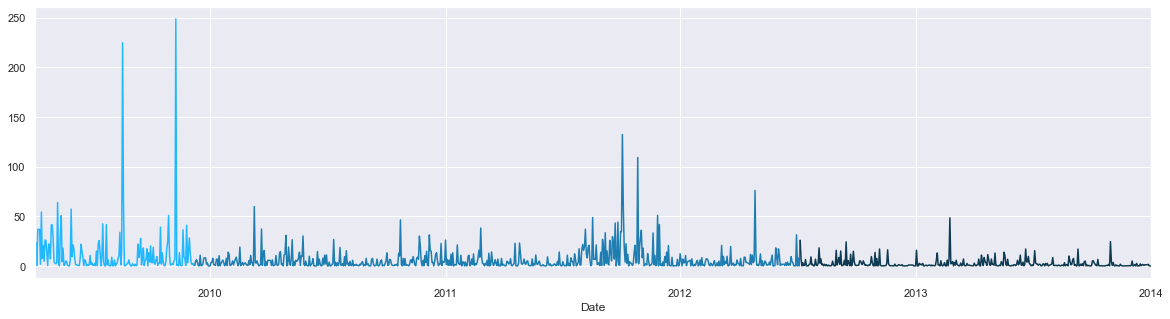

In [40]:
df['sq_vol'][start_date:ann_1].plot(figsize=(20,5), color="#22B8FF")
df['sq_vol'][ann_1:ann_2].plot(color="#1E7EB2")
df['sq_vol'][ann_2: end_date].plot(color="#0E3A52")
plt.show()

## Volatility trend for each period

In [41]:
model_garch_pre = arch_model(df.ret_vol[start_date:ann_1], mean='Constant', vol="GARCH", p=1, q=1)
results_garch_pre = model_garch_pre.fit(update_freq=5)

model_garch_btn = arch_model(df.ret_vol[ann_1:ann_2], mean='Constant', vol="GARCH", p=1, q=1)
results_garch_btn = model_garch_btn.fit(update_freq=5)

model_garch_post = arch_model(df.ret_vol[ann_2:end_date], mean='Constant', vol="GARCH", p=1, q=1)
results_garch_post = model_garch_post.fit(update_freq=5)

Iteration:      5,   Func. Count:     35,   Neg. LLF: 477.60046796009647
Iteration:     10,   Func. Count:     67,   Neg. LLF: 477.53213956897787
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 477.5321384872094
            Iterations: 12
            Function evaluations: 79
            Gradient evaluations: 11
Iteration:      5,   Func. Count:     41,   Neg. LLF: 1519.9906257312582
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1519.9877583592338
            Iterations: 8
            Function evaluations: 61
            Gradient evaluations: 8
Iteration:      5,   Func. Count:     37,   Neg. LLF: 718.0310546142414
Iteration:     10,   Func. Count:     68,   Neg. LLF: 717.9165119474933
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 717.916511947255
            Iterations: 10
            Function evaluations: 68
            Gradient evaluations: 10


In [42]:
results_garch_pre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -477.532
Distribution:                  Normal   AIC:                           963.064
Method:            Maximum Likelihood   BIC:                           975.791
                                        No. Observations:                  178
Date:                Mon, Aug 23 2021   Df Residuals:                      177
Time:                        11:12:03   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.3186      0.265      1.201      0.230 [ -0.201,  0.839]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.5884      0.436      1.348      0.178      [ -0.267,  1.444]
alpha[1]   6.0466e-15  1.343e-02  4.503e-13      1.000 [-2.632e-02,2.632e-02]
beta[1]        0.9492  4.176e-02     22.732 2.175e-114      [  0.867,  1.031]
=============================================================================

Covariance estimator: robust
"""

In [43]:
results_garch_btn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1519.99
Distribution:                  Normal   AIC:                           3047.98
Method:            Maximum Likelihood   BIC:                           3066.02
                                        No. Observations:                  672
Date:                Mon, Aug 23 2021   Df Residuals:                      671
Time:                        11:12:03   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1792  8.598e-02      2.084  3.718e-02 [1.064e-02,  0.348]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.1597  7.533e-02      2.120  3.402e-02   [1.204e-02,  0.307]
alpha[1]       0.0615  1.503e-02      4.094  4.244e-05 [3.208e-02,9.101e-02]
beta[1]        0.9116  1.932e-02     47.181      0.000     [  0.874,  0.950]
============================================================================

Covariance estimator: robust
"""

In [44]:
results_garch_post.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -717.917
Distribution:                  Normal   AIC:                           1443.83
Method:            Maximum Likelihood   BIC:                           1459.70
                                        No. Observations:                  390
Date:                Mon, Aug 23 2021   Df Residuals:                      389
Time:                        11:12:03   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1819  9.500e-02      1.915  5.550e-02 [-4.276e-03,  0.368]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.4608      0.517      0.892      0.373   [ -0.552,  1.474]
alpha[1]       0.1250      0.146      0.855      0.393   [ -0.162,  0.412]
beta[1]        0.6837      0.308      2.222  2.631e-02 [8.053e-02,  1.287]
==========================================================================

Covariance estimator: robust
"""